# Baseline for creating a pipeline to go from positions to galaxy colors

notebook by _Kara Ponder (UC Berkeley)_, _Alex Malz (GCCL@RUB)_, _Ben Moews (Edinburgh)_, add your name here

This notebook currently only runs for a single (and specific) redshift bin (0.080). 

In [1]:
import os
import glob
import pickle

import numpy as np
import pandas as pd
import multiprocessing as mp

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib

import environment as galenv
import corner

%matplotlib inline


## Read in *simulated* data

The data is located on Emille's computer at `/media/CRP6/Cosmology/recidivator/SLICS/`. 

The naming scheme currently (Sept 3, 2019) does not reflect what is actually contained in the CSV. 
You can see below the the "2 deg" file covers 5x5 deg. 
Note: I by hand labeled the columns 'ra' and 'dec'. They do not have titles for the columns on the computer. 

In [7]:
df = pd.read_csv('ang2deg.csv')

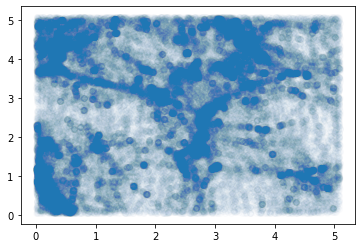

In [8]:
plt.scatter(df['ra'], df['dec'], alpha=0.01)

## Get nearest neighbors

Using the same code as from `environment.ipynb`, get the number of neighbors within a distance. 

First, we randomly select objects from the particle dataframe so that we are not running with too many particles. This is done to make the data easier to run though the notebook and should not be done in the final catalog. 

In [9]:
rand_indicies = np.random.uniform(low=0, high=len(df), size=4000)
datum = df.iloc[rand_indicies].values

In [10]:
chosen_ind = np.random.randint(0, len(datum), 1)[0]
print(chosen_ind)
try_distances = np.flip(np.geomspace(0.01, 1.0, 10), axis=0)
res = []
friends = datum
for dist in try_distances:
    friends = galenv.nn_finder(friends, datum[chosen_ind], dist)
    res.append(len(friends))

126


Text(0, 0.5, 'number of neighbors within distance')

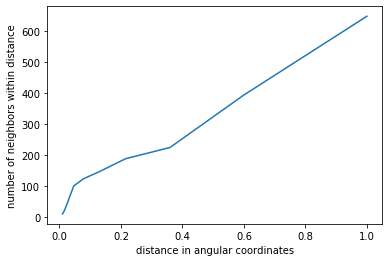

In [11]:
plt.plot(try_distances, res)
plt.xlabel('distance in angular coordinates')
plt.ylabel('number of neighbors within distance')

In [12]:
def calc_env(ind):
    res = [ind]
    friends = data
    for dist in try_distances:
        friends = galenv.nn_finder(friends, data[ind], dist)
        res.append(len(friends))
    return res

We have not broken the particles down into RA/Dec and redshift subsamples as we did the real galaxy data and so we do not need the for-loop.

This also runs much faster than the other notebook (less than a minute versus 5-10 minutes for the real data.)

Also note that this data is called "ra" and "dec" but the actual input is in degrees with no zeropoint to give is a physical location on the sky. 

In [13]:
rand_indicies = np.random.uniform(low=0, high=len(df), size=3000)
data = df.iloc[rand_indicies].values
nps = mp.cpu_count()
pool = mp.Pool(nps - 1)
envs_in_field = pool.map(calc_env, range(len(data)))
pool.close()

In [14]:
# List of environments in the particle data
envs_in_field = np.array(envs_in_field)

Let's look at where our random sample is located in our field of view. 

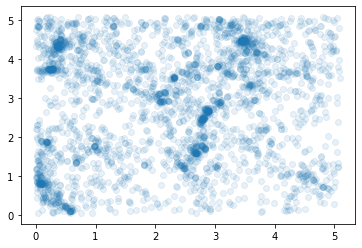

In [15]:
plt.scatter(df['ra'].iloc[rand_indicies], df['dec'].iloc[rand_indicies], alpha=0.1)


### How do the enviornments compare to those found for real galalxies?

In [ ]:
str_red = '0.080'

# this is just the function I use to read the data at specific redshifts
def redshift_df(str_zbin):
    zenvdf = pd.read_csv('enviros.csv') ### <- run environment.ipynb for this file
    r_files = glob.glob('SpecObjPhot/SpecObjPhot*.csv') ### <- run phot_subsample_and_validation.ipynb for these files
    f = [s for s in r_files if str_zbin in s]
    phodf = pd.read_csv(f[0])
    phodf = phodf.drop(columns=['GAMA_NAME', 'IC_FLAG', 
                            'N_SPEC', 'N_GAMA_SPEC', 'DIST', 
                            'SPECID', 'SURVEY', 'SURVEY_CODE',
                            'RA', 'DEC', 'WMIN', 'WMAX', 'Z', 'NQ',
                            'PROB', 'FILENAME', 'URL', 'URL_IMG'])
    df = pd.merge(phodf, zenvdf, on=['CATAID'])
    return df

df_0080 = redshift_df(str_red)

It is clear from the plot below that the simulations create environments that have many more neighbors than the real data. 
There is a much wider range of neighbors at small radial distances and the number that it reaches at large radii is several hundred larger than for real galaxies.

In [ ]:
orig_distances = np.flip(try_distances, axis=0)

fig = plt.figure(figsize=(11,10))
for i in range(int(len(envs_in_field[:,1:])/3.)):
    plt.loglog(try_distances, envs_in_field[i,1:], alpha=0.1, color='r')

plt.loglog(try_distances, envs_in_field[i,1:], alpha=0.1, color='r', label='Simulation') # repeat of the last one to get the legend

# Randomly choose 4000 to match the number chosen from the particle data
## but only plot the same number as the number plotted for the sims
rand_gals = np.random.uniform(low=0, high=len(df_0080), size=4000)

for index, row in df_0080.iloc[rand_gals].iterrows():
    if index < int(len(envs_in_field[:,1:])/3.):
        dist = [str(i) for i in orig_distances]
        plt.loglog(orig_distances, row[dist], 'o-k', alpha=0.2)
        
plt.loglog(orig_distances, row[dist], 'o-k', alpha=0.2, label='Real Galaxies') # repeat of the last one to get the legend

plt.xlabel('radial distance', size=15)
plt.ylabel('# neighbors', size=15)
plt.legend()

# Define functions to get galaxy information

We define three functions that will take an array of environments at a specific redshift and output galaxy properties. 
This assumes that you have already run `environment.ipynb` and have save the clustering model in 

`ts_means/tskmeans_REDSHIFT.pkl` for the appropriate redshift. 

It also assumes that you have run the galaxy photometric properties through the 3D multivariate Gaussian Stan model and have saved the output files in 

`fit_summaries/summary_REDSHIFT_label_LABEL.csv` for each redshift at each label. 

In [ ]:
def get_label(n_r, str_redshift, verbose=False):
    """
    n_r: array of number of neighbors at same radii as TS Kmeans was trained
    redshift: redshift bin to get model
    
    returns: label in an array
    """

    filename = 'ts_kmeans/tskmeans_%s.pkl'% str_redshift
    km = pickle.load(open(filename, 'rb'))
    if len(n_r.shape) == 1:
        predicted = km.predict(n_r.reshape(1, -1))
    else:
        predicted = km.predict(n_r)

    if verbose:
        print("Predicted label is: ", predicted)

    return predicted

In [ ]:
def get_random_sample(label, str_redshift):
    from scipy.stats import multivariate_normal
    rando = []
    for l in label:
        summary = pd.read_csv('fit_summaries/summary_%s_label_%s.csv' %(str_redshift, label[0]))
        mus = summary.iloc[:3]['mean'].values
        cov = summary.iloc[3:]['mean'].values.reshape(3, 3)

        rando.append(multivariate_normal.rvs(mus, cov))
    return rando

def get_properties(n_r, str_redshift, verbose=False):
    l = get_label(n_r, str_redshift, verbose=verbose)
    samp = get_random_sample(l, str_redshift)
    return samp

To check the functionality, I randomly defined a test list of nearest neighbors to run through `get_properties`.

In [ ]:
# Current input takes the nearest neighbors from the largest radii first and goes down in order to the smallest
tester_nr = np.array([650, 600, 500, 200, 100, 10, 2, 1, 1, 1])

get_properties(tester_nr, '0.080', verbose=True)

# Feed particle data to clustering algorithm and draw galaxy properties

In [ ]:
str_red = '0.080'

results = get_properties(envs_in_field[:,1:], str_red)

Plot the MOCK data!

In [ ]:
sc = plt.scatter(np.array(results)[:, 0], np.array(results)[:, 1],
            c=np.array(results)[:, 2],
            cmap=plt.cm.Spectral, 
            vmin=min(np.array(results)[:, 2]),
            vmax=max(np.array(results)[:, 2]),
            alpha=0.5)

cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('lsstr', size=12)

plt.xlabel('r-i', size=15)
plt.ylabel('i-z', size=15)

# Compare mock data to to real galaxy data. 

In [ ]:
jet = plt.cm.Spectral #plt.cm.get_cmap('viridis_r')
cNorm  = colors.Normalize(vmin=0, vmax=20)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
color=scalarMap.to_rgba(np.arange(0, 20))

In [ ]:
# This is the real data in red
fig = corner.corner(np.array([df_0080.loc[(df_0080['lsstz'] > 0) 
                                          & (df_0080['lsstr'] > 0) 
                                          & (df_0080['lssti'] > 0)]['lsstr']
                              - df_0080.loc[(df_0080['lsstz'] > 0) 
                                            & (df_0080['lsstr'] > 0) 
                                            & (df_0080['lssti'] > 0)]['lssti'], 
                              df_0080.loc[(df_0080['lsstz'] > 0) 
                                          & (df_0080['lsstr'] > 0) 
                                          & (df_0080['lssti'] > 0)]['lssti']
                              - df_0080.loc[(df_0080['lsstz'] > 0) 
                                            & (df_0080['lsstr'] > 0) 
                                            & (df_0080['lssti'] > 0)]['lsstz'],
                              df_0080.loc[(df_0080['lsstz'] > 0) 
                                          & (df_0080['lsstr'] > 0) 
                                          & (df_0080['lssti'] > 0)]['lsstr'],
                              ]).T, 
                    #labels=['r-', 'i', 'z'], show_titles=True,
                    range = [(-1.6,1.6), (-1.6,1.6),(15,21)],
                    color=color[1], 
                    plot_density=False, 
                    plot_contours=False,
                    quantiles=[0.5],
                    hist_kwargs={'density': True})

# and the mock data in blue
corner.corner(np.array(results),
              labels=['r-i', 'i-z', 'lsstr'],
              show_titles=True,
              color=color[-3], fig=fig, 
              plot_contours=False, 
              plot_density=False, 
              quantiles=[0.5],
              hist_kwargs={'density': True})

#plt.savefig('final_plot.png')

## Notes from plot above:

- In the red real data, you can see some structure in lsstr which is most likely related to the magnitude limits
- The populations of the real and mock data are slightly different. However, the population of mock data is distinct from the population of real data as seen when we compared the environments above. 
